In [1]:
import pandas, numpy, seaborn

In [2]:
import scipy, scipy.stats
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})

In [33]:
import pyensembl
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

# 0. user-defined variables

In [4]:
regulon_input_file = '/home/adrian/projects/osteo/results/grn/regulons.txt'
expression_data_input_file = '/home/adrian/projects/osteo/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/gd15/hi/research/osteo/metadata/MSC_Sample list.csv'
DEGs_input_file = '/home/adrian/projects/osteo/results/DETs_filtered/entire_DEG_set.txt'
sub_regulon_file = '/home/adrian/projects/osteo/results/grn/subregulons.txt'
dorothea_database_file = '/home/adrian/projects/osteo/data/dorothea/database.txt'

In [5]:
donors = ['6', '16', '17']
days = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

# 1. read data

## 1.1. read expression data

In [6]:
expression = {}
df = pandas.read_csv(expression_data_input_file, sep='\t', index_col=0)
print(df.shape)
df.head()

(61881, 35)


,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000000003,19.335691,18.169915,14.583542,13.268787,11.909277,14.401477,15.508173,16.873705,24.581891,19.646710,...,22.189575,27.176134,26.710900,25.657853,26.080765,23.043590,30.715197,9.531126,13.188327,12.688343
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205061,...,0.000000,0.000000,0.014295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088521
ENSG00000000419,88.588704,66.446158,69.529945,55.187746,56.747577,49.690580,58.582004,56.662479,60.533607,38.837379,...,84.160481,63.976953,55.872238,58.170050,64.176910,62.434239,80.468174,48.148299,52.024370,42.845487
ENSG00000000457,4.894707,3.251930,4.348814,4.041450,2.504120,3.961547,4.147379,3.765491,5.163619,4.747719,...,3.955710,4.220823,3.800248,4.072286,3.508484,4.063589,5.402119,1.238948,1.773441,2.515779
ENSG00000000460,5.143755,3.867982,6.716682,6.850610,4.475370,5.676804,6.286452,6.465416,3.234294,2.350998,...,3.208649,4.862155,3.859008,4.053368,2.695341,2.831406,3.328377,0.523516,0.458589,0.857551


In [7]:
# retrieve DETs for expression
DEGs = []
with open(DEGs_input_file, 'r') as f:
    for line in f:
        element = line.replace('\n', '')
        DEGs.append(element)
print('DEGs found: {}'.format(len(DEGs)))
working_genes = list(set(DEGs))
print(len(working_genes))
print(working_genes[:5])

DEGs found: 1106
1106
['ENSG00000103888', 'ENSG00000187951', 'ENSG00000205683', 'ENSG00000167912', 'ENSG00000103145']


In [8]:
expression = df.loc[working_genes, ]
print(expression.shape)
expression.head()

(1106, 35)


,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000103888,32.125110,28.289886,43.924492,48.801521,32.672565,82.079647,62.842311,61.999255,276.754584,350.335662,...,16.895627,119.342839,129.388010,137.419568,190.967621,192.882212,199.447196,150.892404,143.436125,135.341068
ENSG00000187951,15.820396,8.795067,14.096276,12.674941,7.078377,12.818086,8.548284,5.732391,5.965737,5.922346,...,3.247445,3.514927,3.506952,3.452346,1.262872,1.282300,2.298723,1.162222,0.553462,1.167908
ENSG00000205683,7.720049,15.539084,10.809075,9.961948,6.882018,16.412906,15.432382,13.016716,6.621815,7.348996,...,3.459631,2.036764,2.444767,2.202394,1.117220,1.433559,1.618827,1.223966,1.075293,1.920875
ENSG00000167912,4.060537,4.085447,3.839716,4.445341,3.866101,8.442595,6.896930,8.712594,2.865796,3.671643,...,1.961727,1.872478,1.585932,1.997656,0.879149,0.423299,0.928573,0.154546,0.428720,0.610863
ENSG00000103145,15.822403,10.698321,11.180437,14.559813,15.066963,24.081323,21.901426,26.200244,33.192224,35.505617,...,11.832247,52.712319,52.859903,45.802623,29.246462,27.560758,20.643876,57.067566,60.151412,49.872575


## 1.2. read metadata

In [9]:
def metadata_reader():

    metadata = {}
    donors = []
    days = []

    with open(metadata_file, 'r') as f:
        next(f)
        for line in f:
            v = line.split(',')
            sample = v[0]
            day = v[-2]
            donor = v[-3]
            metadata[sample] = (donor, day)

            if donor not in donors:
                donors.append(donor)
            if day not in days:
                days.append(day)

    return metadata, donors, days

In [10]:
metadata, donors, days = metadata_reader()

## 1.3. read TFs from Dorothea and convert them to ENSEMBL IDs

In [ ]:
with open(dorothea_database_file, 'r') as f:
    for line in f:
        print

# 2. analysis

## 2.1. PCA

In [11]:
# highly-expressed genes
#HEGs = expression[(expression.sum(axis=1)/expression.shape[1]) > 5]

In [12]:
pca_input = expression.transpose()
#pca_input = HEGs.transpose()

pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(35, 2)
[0.5220307  0.10373583]


In [13]:
sampleIDs = expression.columns.to_list()
print(sampleIDs)

['thBS_MSC_1', 'thBS_MSC_3', 'thBS_MSC_4', 'thBS_MSC_5', 'thBS_MSC_6', 'thBS_MSC_7', 'thBS_MSC_8', 'thBS_MSC_9', 'thBS_MSC_10', 'thBS_MSC_11', 'thBS_MSC_12', 'thBS_MSC_13', 'thBS_MSC_14', 'thBS_MSC_15', 'thBS_MSC_19', 'thBS_MSC_20', 'thBS_MSC_21', 'thBS_MSC_22', 'thBS_MSC_23', 'thBS_MSC_24', 'thBS_MSC_25', 'thBS_MSC_26', 'thBS_MSC_27', 'thBS_MSC_28', 'thBS_MSC_29', 'thBS_MSC_30', 'thBS_MSC_31', 'thBS_MSC_32', 'thBS_MSC_33', 'thBS_MSC_37', 'thBS_MSC_38', 'thBS_MSC_39', 'thBS_MSC_43', 'thBS_MSC_44', 'thBS_MSC_45']


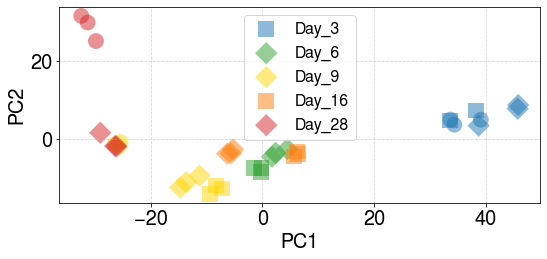

In [14]:
working_labels = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

for i in range(len(sampleIDs)):
    
    treatment_day = metadata[sampleIDs[i]][1]
    patient_id = metadata[sampleIDs[i]][0]
    
    # color based on treatment day
    if treatment_day == 'Day_3':
        the_color='tab:blue' 
    elif treatment_day == 'Day_6':
        the_color='tab:green'
    elif treatment_day == 'Day_9':
        the_color='gold'
    elif treatment_day == 'Day_16':
        the_color='tab:orange'
    elif treatment_day == 'Day_28':
        the_color='tab:red'
    else:
        raise ValueError('computer says no')
        
    # marker based on patient ID
    if patient_id == '6':
        the_marker = 'o'
    elif patient_id == '16':
        the_marker = 's'
    elif patient_id == '17':
        the_marker = 'D'
    else:
        raise ValueError('computer says no again')
        
    # labels
    if treatment_day in working_labels:
        the_label=treatment_day
        working_labels.remove(treatment_day)
    else:
      the_label=''
      
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=250, alpha=0.5, edgecolors='none', marker=the_marker, label=the_label)

matplotlib.pyplot.legend(fontsize=16)
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.savefig('pca.svg')

## 2.2. RUNX2-PPARG 

In [15]:
# RUNX2 ==>  ENSG00000124813
# PPARG ==> ENSG00000132170
targets=['ENSG00000124813', 'ENSG00000132170'] 

In [16]:
sub = expression.loc[targets, ]
sub

,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000124813,13.297374,22.447391,16.519808,14.831718,10.686293,8.988245,10.756189,7.257497,44.557240,74.939293,...,14.180360,40.920211,40.579583,42.671255,40.334031,33.96801,47.458071,17.801390,18.680744,17.705067
ENSG00000132170,5.465651,2.825620,0.781200,1.574319,1.231893,3.725705,5.251543,4.564146,6.918534,7.137037,...,5.812747,14.329348,15.772878,3.776372,12.643850,12.46467,24.148982,18.055275,18.760832,21.395034


In [17]:
sampleIDs = sub.columns.to_list()

Day_3
16
[3.73306951 4.48847584]
17
[4.04612503 3.89061379 3.41768964]
6
[3.16803952 3.42709517 2.85947216]
[4.1107726719347495, 3.784809482978975, 3.1515356165232453] mean 3.784809482978975
Day_6
16
[3.51230178 4.79970434 4.57564739]
17
[5.47758797 6.22765045 5.4897122 ]
6
[]
[4.295884504390294, 5.731650207012399] mean 5.013767355701347
Day_9
16
[4.38279771 4.18536575 4.04890806]
17
[5.70619506 5.78410948 5.60273567]
6
[4.91458357 4.96319538 4.87052756]
[4.205690506043592, 5.697680069312934, 4.916102170183014] mean 4.916102170183014
Day_16
16
[3.63055223 3.64568012 3.8258223 ]
17
[5.35474167 5.34268213 5.41519264]
6
[]
[3.700684884154302, 5.370872145898875] mean 4.535778515026588
Day_28
16
[]
17
[5.33392568 5.08610479 5.56858155]
6
[4.15391803 4.22348001 4.14609042]
[5.329537341403047, 4.174496150869003] mean 4.752016746136025
ENSG00000124813
[3.6823725904789897, 5.013767355701347, 4.93982424851318, 4.535778515026588, 4.752016746136025]
Day_3
16
[2.45039326 1.49856746]
17
[-0.35623658

/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


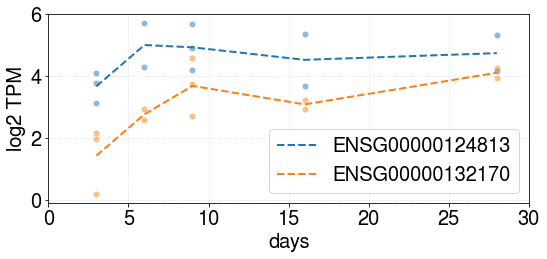

In [18]:
the_colors = ['tab:blue', 'tab:orange']
for i in range(len(sub.index)):
    working_gene = sub.index[i]
    the_color = the_colors[i]
    
    trajectory = []
    pointsy = []; pointsx = []
    for day in days:
        print(day)
        patient_expression_values = []
        for donor in donors:
            print(donor)
            # retrieve sample labels
            sample_labels = []
            for sample in sampleIDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)

            # retrieve expression
            exp = numpy.log2([sub[label][working_gene] for label in sample_labels])
            print(exp)

            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                patient_expression_values.append(average_expression)
                pointsy.append(average_expression)
                pointsx.append(int(day.split('_')[1]))

        # compute median across patients
        median_expression = numpy.mean(patient_expression_values)
        print(patient_expression_values, 'mean', numpy.median(patient_expression_values))

        # add median value to trajectory
        trajectory.append(median_expression)        

    print(working_gene)
    print(trajectory)
    
    # plot median trajectory
    matplotlib.pyplot.plot([3, 6, 9, 16, 28], trajectory, lw=2, ls='--', label=working_gene, color=the_color)
    matplotlib.pyplot.plot(pointsx, pointsy, 'o', alpha=0.5, color=the_color, mew=0)
    
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlim([0, 30])
matplotlib.pyplot.ylabel('log2 TPM')
matplotlib.pyplot.xlabel('days')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('toggle_switch.svg')

In [19]:
expression.head()

,thBS_MSC_1,thBS_MSC_3,thBS_MSC_4,thBS_MSC_5,thBS_MSC_6,thBS_MSC_7,thBS_MSC_8,thBS_MSC_9,thBS_MSC_10,thBS_MSC_11,...,thBS_MSC_30,thBS_MSC_31,thBS_MSC_32,thBS_MSC_33,thBS_MSC_37,thBS_MSC_38,thBS_MSC_39,thBS_MSC_43,thBS_MSC_44,thBS_MSC_45
ENSG00000103888,32.125110,28.289886,43.924492,48.801521,32.672565,82.079647,62.842311,61.999255,276.754584,350.335662,...,16.895627,119.342839,129.388010,137.419568,190.967621,192.882212,199.447196,150.892404,143.436125,135.341068
ENSG00000187951,15.820396,8.795067,14.096276,12.674941,7.078377,12.818086,8.548284,5.732391,5.965737,5.922346,...,3.247445,3.514927,3.506952,3.452346,1.262872,1.282300,2.298723,1.162222,0.553462,1.167908
ENSG00000205683,7.720049,15.539084,10.809075,9.961948,6.882018,16.412906,15.432382,13.016716,6.621815,7.348996,...,3.459631,2.036764,2.444767,2.202394,1.117220,1.433559,1.618827,1.223966,1.075293,1.920875
ENSG00000167912,4.060537,4.085447,3.839716,4.445341,3.866101,8.442595,6.896930,8.712594,2.865796,3.671643,...,1.961727,1.872478,1.585932,1.997656,0.879149,0.423299,0.928573,0.154546,0.428720,0.610863
ENSG00000103145,15.822403,10.698321,11.180437,14.559813,15.066963,24.081323,21.901426,26.200244,33.192224,35.505617,...,11.832247,52.712319,52.859903,45.802623,29.246462,27.560758,20.643876,57.067566,60.151412,49.872575


## 2.3. volcano plot

In [20]:
# obtain a TPM trajectory (discrete for very low) across time over replicates and patients
expression_trajectories = {}

for working_gene in working_genes:
    
    ensembl_trajectory = []
    for day in days:
        expression_across_donors = []
        for donor in donors:
            
            # retrieve sample labels
            sample_labels = []
            for sample in sampleIDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)
            
            # retrieve expression
            try:
                exp = [expression[label][working_gene] for label in sample_labels]
            except:
                exp = [0 for label in sample_labels]
                print('ENSEMBL ID {} not found in expression data set. Setting expression to zero.'.format(working_gene))
                    
            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                expression_across_donors.append(average_expression)
                
        # compute median across patients
        median_expression = numpy.median(expression_across_donors)
        
        # round values, useful for very low values
        round_value = numpy.around(median_expression) + 1
        
        # add round value to trajectory
        ensembl_trajectory.append(round_value)
    
    # add trajectory to dictionary
    expression_trajectories[working_gene] = ensembl_trajectory

/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
expression_trajectories

{'ENSG00000103888': [43.0, 241.0, 307.0, 73.0, 170.0],
 'ENSG00000187951': [12.0, 7.0, 4.0, 4.0, 2.0],
 'ENSG00000205683': [13.0, 6.0, 4.0, 4.0, 2.0],
 'ENSG00000167912': [5.0, 5.0, 4.0, 3.0, 2.0],
 'ENSG00000103145': [15.0, 35.0, 54.0, 32.0, 42.0],
 'ENSG00000165995': [2.0, 6.0, 6.0, 6.0, 9.0],
 'ENSG00000099998': [47.0, 166.0, 247.0, 328.0, 559.0],
 'ENSG00000133321': [2.0, 10.0, 16.0, 9.0, 10.0],
 'ENSG00000003436': [41.0, 71.0, 54.0, 73.0, 114.0],
 'ENSG00000104368': [68.0, 39.0, 22.0, 50.0, 61.0],
 'ENSG00000214402': [1.0, 3.0, 3.0, 1.0, 2.0],
 'ENSG00000104415': [38.0, 33.0, 103.0, 134.0, 138.0],
 'ENSG00000204103': [1.0, 2.0, 3.0, 3.0, 5.0],
 'ENSG00000149090': [11.0, 16.0, 4.0, 8.0, 3.0],
 'ENSG00000167549': [7.0, 12.0, 24.0, 9.0, 24.0],
 'ENSG00000175899': [1.0, 2.0, 2.0, 2.0, 12.0],
 'ENSG00000139793': [13.0, 21.0, 19.0, 20.0, 43.0],
 'ENSG00000147155': [33.0, 20.0, 19.0, 16.0, 8.0],
 'ENSG00000182272': [5.0, 3.0, 4.0, 2.0, 2.0],
 'ENSG00000125945': [2.0, 4.0, 6.0, 4.0, 5.0],

In [22]:
plotting_df = pandas.DataFrame(expression_trajectories).transpose()
plotting_df.columns = days
plotting_df.head()

,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000103888,43.0,241.0,307.0,73.0,170.0
ENSG00000187951,12.0,7.0,4.0,4.0,2.0
ENSG00000205683,13.0,6.0,4.0,4.0,2.0
ENSG00000167912,5.0,5.0,4.0,3.0,2.0
ENSG00000103145,15.0,35.0,54.0,32.0,42.0


In [23]:
plotting_df['log2_average_TPM'] = numpy.log2(plotting_df[['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']].mean(axis=1))
plotting_df

,Day_3,Day_6,Day_9,Day_16,Day_28,log2_average_TPM
ENSG00000103888,43.0,241.0,307.0,73.0,170.0,7.381975
ENSG00000187951,12.0,7.0,4.0,4.0,2.0,2.536053
ENSG00000205683,13.0,6.0,4.0,4.0,2.0,2.536053
ENSG00000167912,5.0,5.0,4.0,3.0,2.0,1.925999
ENSG00000103145,15.0,35.0,54.0,32.0,42.0,5.153805
...,...,...,...,...,...,...
ENSG00000156970,14.0,4.0,2.0,4.0,2.0,2.378512
ENSG00000121621,7.0,4.0,3.0,4.0,2.0,2.000000
ENSG00000084674,1.0,5.0,6.0,2.0,5.0,1.925999
ENSG00000100526,21.0,10.0,4.0,11.0,2.0,3.263034


In [24]:
plotting_df['log2FC_28_vs_3'] = numpy.log2(plotting_df['Day_28']/plotting_df['Day_3'])
plotting_df.shape

(1106, 7)

In [25]:
plotting_df = plotting_df[plotting_df['log2_average_TPM'] > 1]
plotting_df.shape

(1074, 7)

In [26]:
plotting_df = plotting_df[numpy.abs(plotting_df['log2FC_28_vs_3']) > 1]
plotting_df.shape

(941, 7)

In [27]:
x = plotting_df['log2FC_28_vs_3']
y = plotting_df['log2_average_TPM']

In [32]:
# get TFs as orange and metabolic genes as green
ensembl_IDs = list(plotting_df.index.values)
print(len(ensembl_IDs), ensembl_IDs[:5])

the_colors = []
for element in x:
    the_colors.append('black')

941 ['ENSG00000103888', 'ENSG00000187951', 'ENSG00000205683', 'ENSG00000167912', 'ENSG00000103145']


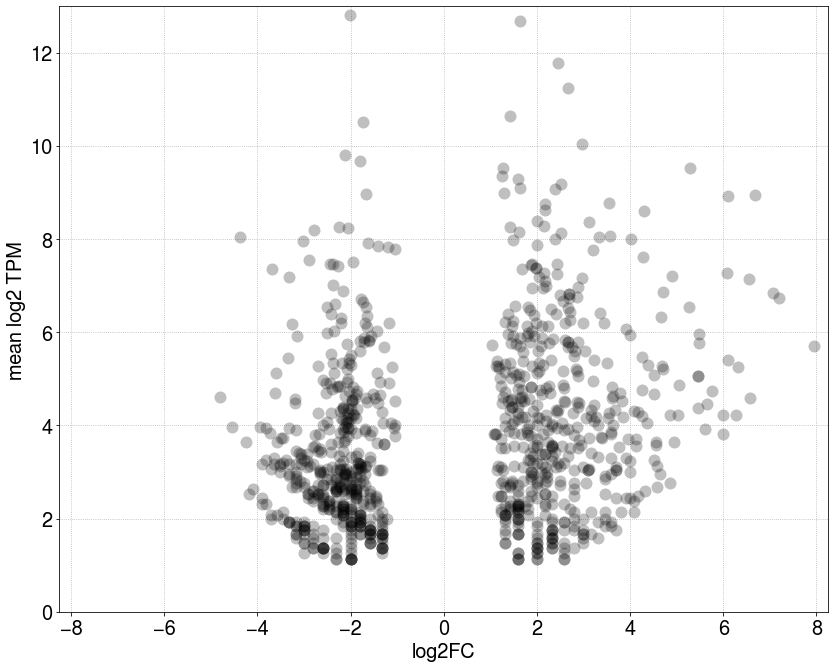

In [29]:
matplotlib.pyplot.figure(figsize=(12, 12))

for i in range(len(x)):
    matplotlib.pyplot.plot(x[i], y[i], 'o', color=the_colors[i], alpha=1/4, mew=0, ms=12)

matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.xlim([-8.25, 8.25])
matplotlib.pyplot.ylim([0, 13])
matplotlib.pyplot.xlabel('log2FC')
matplotlib.pyplot.ylabel('mean log2 TPM')
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()